In [1]:
import matplotlib.pyplot as plt                # For Plotting
import numpy as np                             # For Environment Operations
import random                                  # For Genetic Algorithm  
import imageio                                 # For video recording actions
import gym                                     # The General Framework of the environment
import math                                    # Distance Calculations 
import copy                                    # Deep and shallow copies
import os                                      # Write maze runner records to disk
import pandas as pd                            # Data Analysis
import sys                                     # Flush stdout
from IPython.display import Image as Img       # Show Gifs of the Records in Notebook
from pathlib import Path                       # Image, Record paths
from mazelab import BaseMaze                   # The Framework of the environment
from mazelab import Object                  
from mazelab import DeepMindColor as color
from mazelab import BaseEnv                    # Base Environment Class
from mazelab import VonNeumannMotion           # North, South, West, East Motions
from gym.envs.classic_control import rendering # For rendering images
from gym.spaces import Box                     
from gym.spaces import Discrete
from PIL import Image                          # Rendering images

In [2]:
class Env(BaseEnv):
    """
    The environment of the Maze Solver
    
    Defines basics like stepping, rendering maze to image and also supports video recording with the help of BaseEnv
    """
    
    def __init__(self):
        super().__init__()
        # Set Maze
        self.maze = maze_env.get_maze()
        # Define Observation Space
        self.observation_space = Box(low=0, high=len(self.maze.objects), shape=self.maze.size, dtype=np.uint8)
        # Set Actions
        self.motions = VonNeumannMotion()
        # Define Action Space
        self.action_space = Discrete(len(self.motions))
    
    def step(self, action):
        """
        Take action on the environment
        """
        # Take the motion that the action points
        motion = self.motions[action]                      # North, South, West, East Motions
        # Take the agent's current position
        current_position = self.maze.objects.agent.positions[0]
        # Calculate new position after we take the action
        new_position = [current_position[0] + motion[0], current_position[1] + motion[1]]
        # check whether the the new position is a wall or something alike
        valid = self._is_valid(new_position)
        
        # If the result of the action to be taken is a valid position, then update the agent's position
        if valid:
            self.maze.objects.agent.positions = [new_position]
        
        # Since we use Reinforcement Learning, we give rewards to actions
        reward = 0
        # If the goal position is reached
        if self._is_goal(new_position): 
            reward = 10_000                
            done = True
        # If the position is wall
        elif not valid:
            reward = -100
            done = False
        # Since every step takes time, 
        # we give punishment for every step taken to make the agent minimize n_steps
        else:
            reward = -10
            done = False
        # Return state,reward, done, info
        return self.s, reward, done, {}
    
    
    def encode(self, agent_x, agent_y):
        """
        Change the state of the environment 
        into another by moving the agent to given position
        """
        self.maze.objects.agent.positions[0] = [agent_x, agent_y]
        return self.s
    
    def get_maze(self):
        """
        Get maze in matrix form.
        Here 2 shows the agent's position, 
        3 shows the goal position and 1s shows the walls
        """
        return self.maze.to_value()
    
    def reset(self):
        """
        Reset the Maze to the initial state
        """
        self.maze.objects.agent.positions = maze_env.start_idx
        self.maze.objects.goal.positions = maze_env.goal_idx
        return self.s
    
    def _is_valid(self, position):
        """
        Is given position valid? or the position have some obstacle?
        """
        nonnegative = position[0] >= 0 and position[1] >= 0
        within_edge = position[0] < self.maze.size[0] and position[1] < self.maze.size[1]
        passable = not self.maze.to_impassable()[position[0]][position[1]]
        return nonnegative and within_edge and passable
    
    def _is_goal(self, position):
        """
        Have we reached to the goal position?
        """
        out = False
        goal_position = self.maze.objects.goal.positions[0]
        if goal_position[0] == position[0] and goal_position[1] == position[1]:
            return True
        return False
    
    def get_image(self):
        """
        Convert the maze to RGB Array so that we can print it out
        """
        return self.maze.to_rgb()
    
    def render(self, mode='human', max_width=500):
        """
        Print the maze as image of max_width length.
        
        Here careful to max_width, it can make the image blurry if not equal to the actual size of the image 
        """
        # Get the image of the maze
        img = self.get_image()
        # Conver the image into RGB array
        img = np.asarray(img).astype(np.uint8)
        # Scale up the image by 10 without loosing any quality
        # Here be careful, for big mazes, 10 may be high
        img = Env.repeat_upsample(img,10, 10)
        # Return the image
        img = np.asarray(img)
        if mode == 'rgb_array':
            return img
        elif mode == 'human':
            from gym.envs.classic_control.rendering import SimpleImageViewer
            if self.viewer is None:
                self.viewer = SimpleImageViewer()
            self.viewer.imshow(img)
            
            return self.viewer.isopen
        
    @property
    def s(self):
        """
        Get the state of the maze
        Every state is a mapping from agent's position(x,y) to Szudzik Pairing Value 
        """
        x,y = self.maze.objects.agent.positions[0]
        return Env.pair(x,y)
    
    def get_agent_position(self):
        """
        Simple unpair the state(Szudzik Pairing Value) to get the agent's positions
        """
        return Env.unpair(self.s)
        
    @staticmethod
    def pair(x,y):
        """
        By using Szudzik Pairing, get the one dimentional value for x,y pair
        """
        return y*y+x if y > x else x*x+x+y

    @staticmethod
    def unpair(z):
        """
        Get the x,y coordinates back from the Szudzik Pairing Value
        """
        q = math.floor(math.sqrt(z))
        l = z - q ** 2
        return (l, q) if l < q else (q,(l-q)) 
    
    @staticmethod
    def repeat_upsample(rgb_array, k=1, l=1, err=[]):
        """
        Upscale the maze image by KxL
        
        Taken from https://github.com/openai/gym/issues/550
        """
        # repeat kinda crashes if k/l are zero
        if k <= 0 or l <= 0: 
            if not err: 
                print(f"Number of repeats must be larger than 0, k: {k}, l: {l}, returning default array!")
                err.append('logged')
            return rgb_array

        # repeat the pixels k times along the y axis and l times along the x axis
        # if the input image is of shape (m,n,3), the output image will be of shape (k*m, l*n, 3)

        return np.repeat(np.repeat(rgb_array, k, axis=0), l, axis=1)

In [3]:
class MazeEnvironment:
    """
    Initiate appropriate Maze with the provided sizes and obstacle lengths
    """
    def __init__(self, size, k, obstacle_len=4):
        self.size = size
        self.k = k
        self.obstacle_len = obstacle_len
        self.env = self.generate_env()
        
        self.start_idx = [[1, 1]]
        self.goal_idx = [[self.size[0]-2, self.size[1]-2]]
        self.env_id = 'SimpleEmptyMaze-v0'
        # Register the environment, here the max episode steps should be high 
        # so that we make sure the agent met the goal position
        try:
            gym.envs.register(id=self.env_id, entry_point=Env, max_episode_steps=20_000)
        except:
            del gym.envs.registration.registry.env_specs[self.env_id]
            gym.envs.register(id=self.env_id, entry_point=Env, max_episode_steps=20_000)
    
    def get_maze(self):
        """
        Get the maze where every position is defined strictly.
        0 -> Free
        1 -> Obstacle
        2 -> Agent
        3 -> Goal
        """
        x = self.env
        class Maze(BaseMaze):
            @property
            def size(self):
                return x.shape

            def make_objects(self):
                free = Object('free', 0, color.free, False, np.stack(np.where(x == 0), axis=1))
                obstacle = Object('obstacle', 1, color.obstacle, True, np.stack(np.where(x == 1), axis=1))
                agent = Object('agent', 2, color.agent, False, [])
                goal = Object('goal', 3, color.goal, False, [])
                return free, obstacle, agent, goal
        return Maze()
    
    def set_start(start_idx):
        """
        Update start index
        """
        self.start_idx = start_idx
    
    def set_goal(goal_idx):
        """
        Update goal index
        """
        self.goal_idx = goal_idx
    
    def generate_env(self):
        """
        k -> number of obstacles
        """
        # Start environment with array of Zeros where 0's are free spaces, 1's are the walls
        arr = np.zeros(shape=self.size, dtype=int)
        # Create Left-Right Walls
        for i in range(self.size[0]):
            arr[i, 0] = 1
            arr[i, self.size[1] - 1] = 1

        # Create Bottom-Up Walls
        for i in range(self.size[1]):
            arr[0, i] = 1
            arr[self.size[0] - 1, i] = 1

        # Now environment walls are generated now lets add obstacles

        # Generate k Obstacles
        for i in range(self.k):
            # Choose random point to put the current obstacle
            row = random.randrange(1, self.size[0] - 1 - self.obstacle_len)
            column = random.randrange(1, self.size[1] - 1 - self.obstacle_len)

            # Roll dice to decide whether to put the obstacle in vertical or in horizontal shape
            isVertical = random.randint(0, 1)
            if isVertical == 1:
                for j in range(self.obstacle_len):
                    arr[row, column + j] = 1
            else:
                for j in range(self.obstacle_len):
                    arr[row + j, column] = 1

        return arr

In [4]:
#Function to choose the next action 
def choose_action(state, epsilon): 
    action=0
    # Decide whether or not go random or use qtable
    if random.uniform(0,1) < epsilon: 
        action = env.action_space.sample()              # Explore the action space
    else:
        action = np.argmax(q_table[state])              # Use learnt q-values
    return action 

In [5]:
#Function to learn the Q-value 
def update(q_table, alpha, gamma, state, state2, reward, action, action2): 
    predict = q_table[state, action] 
    target = reward + gamma * q_table[state2, action2] 
    q_table[state, action] = q_table[state, action] + alpha * (target - predict) 

In [6]:
def train(env, q_table, n_episodes, alpha, gamma, epsilon):
    for i in range(1, n_episodes):
        state = env.reset()                                     # Start
        action = choose_action(state, epsilon)
        epochs, penalties, reward = 0, 0, 0                     # init variables
        done = False
        
        while not done:                                         # while the agent has not finished
            # Act and get respond from the environment
            next_state, reward, done, _ = env.step(action)
            
            next_action = choose_action(next_state, epsilon)
            
            # Update Q-Value of the current state
            update(q_table, alpha, gamma, state, next_state, reward, action, next_action);
            
            if reward == -100:
                penalties += 1
            
            state = next_state 
            action = next_action 
        
            epochs += 1

In [7]:
def visualize(env, q_table):
    img = env.render('rgb_array')
    env = gym.wrappers.Monitor(env, './', force=True, uid=random.randint(0, 100))
    state = env.reset()
    done = False
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)
    env.close()
    f = list(Path('./').glob('*.mp4'))[0]
    reader = imageio.get_reader(f)
    f = f'./{maze_env.env_id}.gif'
    with imageio.get_writer(f, fps=50) as writer:
        [writer.append_data(img) for img in reader]
    return Img(f)

# Using Q-Learning

## 1- 20 x 20 Maze With 10 Obstacles

In [8]:
# This one has to be defined globally because of how the Env is defined.
maze_env = MazeEnvironment((20, 20), 10)

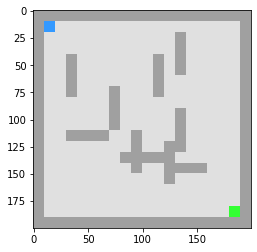

In [9]:
env = gym.make(maze_env.env_id)
env.reset()
img = env.render('rgb_array')
plt.imshow(img)

In [10]:
# Lets get the number of states for the current environment wihch is 20x20
n_states = Env.pair(env.maze.size[0], env.maze.size[1]) # Get Maximum State Number
n_states # The position of agent expresses the state of the board

440

In [11]:
# Now we get the size of the possible actions
n_actions = env.action_space.n 
n_actions # North, South, West, East in this order

4

In [12]:
# Now it's time to create q_table which is a mapping of every state to every action
q_table = np.zeros([n_states, n_actions])        # Table of n_states x n_actions
q_table.shape

(440, 4)

In [ ]:
train(env, q_table, 10_000, alpha=0.4, gamma=0.65, epsilon=0.35)

In [ ]:
visualize(env, q_table)

## 2- 20 x 20 Maze With 20 Obstacles

In [ ]:
maze_env = MazeEnvironment((20, 20), 20)

In [ ]:
env2 = gym.make(maze_env.env_id)
env2.reset()
img2 = env2.render('rgb_array')
plt.imshow(img2)

In [ ]:
q_table2 = np.zeros([Env.pair(env2.maze.size[0], env2.maze.size[1]), env2.action_space.n ])
q_table2.shape

In [ ]:
train(env2, q_table2, 10_000, alpha=0.4, gamma=0.65, epsilon=0.35)

In [ ]:
visualize(env2, q_table2)

## 3- 40 x 40 Maze With 20 Obstacles

In [ ]:
maze_env = MazeEnvironment((40, 40), 20)

In [ ]:
env3 = gym.make(maze_env.env_id)
env3.reset()
img3 = env3.render('rgb_array')
plt.imshow(img3)

In [ ]:
q_table3 = np.zeros([Env.pair(env3.maze.size[0], env3.maze.size[1]), env3.action_space.n ])
q_table3.shape

In [ ]:
train(env3, q_table3, 1_000, alpha=0.4, gamma=0.65, epsilon=0.35)

In [ ]:
visualize(env3, q_table3)

## 4- 40 x 40 Maze With 50 Obstacles

In [ ]:
def getMaze():
    env = gym.make(maze_env.env_id)
    env.reset()
    img = env.render('rgb_array')
    plt.imshow(img)
    q_table = np.zeros([Env.pair(env.maze.size[0], env.maze.size[1]), env.action_space.n ])
    
    return env, q_table

In [ ]:
maze_env = MazeEnvironment((40, 40), 50)
env4, q_table4 = getMaze()

In [ ]:
train(env4, q_table4, 1_000, alpha=0.4, gamma=0.65, epsilon=0.35)

In [ ]:
visualize(env4, q_table4)